<h1 style="color:#555; font-size:3em;">Transfer Learning Experiments Ordered</h1>

In [3]:
from time import time
from copy import deepcopy

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.model_selection import train_test_split

from torch import nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torchsummary import summary

from models.inception_resnet_v1 import InceptionResnetV1

In [4]:
state_dict_unalt = InceptionResnetV1().state_dict().copy()

# 1. Loading the data

In [5]:
def get_mean_std(path):
    dataset = ImageFolder(path)
    tr = transforms.ToTensor()
    imgs = []
    for i in dataset:
        imgs.append(tr(i[0]))
    # dataset
    imgs = torch.stack(imgs)
    mean = imgs.mean(axis=(0,2,3))
    std  = imgs.std(axis=(0,2,3))
    return mean, std

def get_transforms(mean,std,add_jitter=True):
    data_trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ])
    if add_jitter:
        data_trans.transforms.insert(0,transforms.ColorJitter(0.3,0.3,0.3))
    return data_trans

In [8]:
dataset_paths = [
    ("./data/augmented/test/",False),
    ("./data/augmented/train/",True),
    ("./data/classified_test/",False),
    ("./data/classified_crops/",True)
]

datasets = []

for path,add_jitter in dataset_paths:
    mean,std = get_mean_std(path)
    data_trans = get_transforms(mean,std,add_jitter)
    datasets.append(ImageFolder(path,data_trans))

data_set_test_aug,data_set_all_aug, data_set_test, data_set_all = datasets

data_set_test_aug,data_set_all_aug, data_set_test, data_set_all

(Dataset ImageFolder
     Number of datapoints: 256
     Root location: ./data/augmented/test/
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=tensor([0.5011, 0.4659, 0.4509]), std=tensor([0.2670, 0.2682, 0.2675]))
            ),
 Dataset ImageFolder
     Number of datapoints: 1024
     Root location: ./data/augmented/train/
     StandardTransform
 Transform: Compose(
                ColorJitter(brightness=[0.7, 1.3], contrast=[0.7, 1.3], saturation=[0.7, 1.3], hue=None)
                ToTensor()
                Normalize(mean=tensor([0.5123, 0.4697, 0.4572]), std=tensor([0.2617, 0.2604, 0.2595]))
            ),
 Dataset ImageFolder
     Number of datapoints: 38
     Root location: ./data/classified_test/
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=tensor([0.4680, 0.3440, 0.2921]), std=tensor([0.2650, 0.2231, 0.2056]))
            ),
 Dataset ImageFolder
     Number of datap

## 1.1 Create a striated split dataloader

In [11]:
targets = np.array(data_set_all.targets)
idx = train_test_split(torch.arange(len(targets)), shuffle=True, stratify=targets, random_state=34, test_size=0.2)

g = np.gcd(len(idx[0]),len(idx[1])) 
batch_size = g if g > 4 and g < 16 else 5

sets = ['train', 'valid']
tr, va = sets

indices = { x:idx[i] for i,x in enumerate(sets) }
samplers = { x:SubsetRandomSampler(indices[x]) for x in sets }
dataloaders = { x:DataLoader(data_set_all,int(batch_size),sampler=samplers[x],drop_last=True) for x in sets }
data_count = { x:len(indices[x]) for x in sets }

### 1.1.1 DataLoaders for the augmented datasets

In [12]:
targets_aug = np.array(data_set_all_aug.targets)
idx_aug = train_test_split(torch.arange(len(targets_aug)), shuffle=True, stratify=targets_aug, random_state=34, test_size=0.2)

g_aug = np.gcd(len(idx_aug[0]),len(idx_aug[1])) 
batch_size_aug = 10

indices_aug = { x:idx_aug[i] for i,x in enumerate(sets) }
samplers_aug = { x:SubsetRandomSampler(indices_aug[x]) for x in sets }
dataloaders_aug = { x:DataLoader(data_set_all_aug,int(batch_size_aug),sampler=samplers_aug[x],drop_last=True) for x in sets }
data_count_aug = { x:len(indices_aug[x]) for x in sets }

___

# 2. Distance based loss function


- Loss functon will work only with a batch.
- Will take the n-dim vector representation of images and the labels.
- Then calculate the distance between each other.
- If the labels match the distance should be less.
- If the labels don't match the distance should be more.  

**Note -**
Pairwise distance is the generalization of euclidean distance
i.e. when p = 2, pairwise distance == euclidean distance.

In [13]:
class DistLoss:
    def __init__(self,sim_slink=4.3, dis_thresh=1.9, eps=0.8, \
                 dist_func=nn.PairwiseDistance(p=2,eps=1e-8)):
        """
        sim_slink: how exp the sim_loss grows after 1
        dis_thresh: after this dis_thresh, dis_loss < 0
        eps: factor to raise the dissimilar term by.
        dis_func: function to calculate distance between two vectors.
        """
        self.sim_slink = sim_slink
        self.dis_thresh = dis_thresh
        self.eps = eps
        self.dist_func = dist_func
        
    def dist_calculator(self, x1, x2):
        """
        Function that calculates the distances between
        all the vectors in x1 and x2 which are of the
        shape (m1,n) and (m2,n).

        n: dimensions in vector
        m1, m2: co-ordinates in x1 and x2 

        returns: (m2,m1) shape distance matrix
        """
        dists = []
        for vec in x1:
            dists.append(self.dist_func(x2,vec))
        return torch.stack(dists)   
    
    def __call__(self, y_vectors:"vectors from the model", y:"labels"):
        """
        Loss function to be used if the output of the model is 
        an image embedding and the class of the image is known.

        Calculates the distance between all the y_vectors.
        If the classes match the distance > sim_thresh increases the loss 
        If the classes don't match the distance > 1 + dis_offset decreases loss
        """
        """
        When the dis_thresh is crossed by the dissimilar mean the loss contributed by 
        that term will be < 0
        """
        t = lambda n: torch.tensor(n,requires_grad=True)
        rsm = 1e-8
        
        dist_calculator = self.dist_calculator
        sim_slink = self.sim_slink
        dis_thresh = self.dis_thresh
        eps = self.eps

        l = y_vectors.size(0)

        # Distance between all the y_vectors shape:(l,l)
        dist_matrix = dist_calculator(y_vectors, y_vectors)

        # Creating a shape:(l,l) mask using labels
        y_cross = y.repeat(l).reshape(l,l)
        y_mask = torch.eq(y_cross, y_cross.T)

        # mean tensor of dissimilar classes distances
        dis_mean = dist_matrix[~y_mask].mean()

        # Negating the diagonal cause that dist will be (almost) 0
        temp_tensor = torch.arange(l)
        y_mask[temp_tensor,temp_tensor] = False

        # mean tensor of similar classes distances
        sim_mean = dist_matrix[y_mask].mean()
        
        # possible nan if batch has all similar or dissimilar classes
        if torch.isnan(sim_mean):
            sim_mean = t(rsm)
        if torch.isnan(dis_mean):
            dis_mean = t(rsm)
        
        # Loss contributed by similar and dissimilar classes
        sim_loss = sim_mean ** t(sim_slink)
        dis_loss = torch.max(t(dis_thresh)/dis_mean - t(1.), t(rsm)) ** t(eps)
        
        loss = torch.log(sim_loss + dis_loss + t(1.))
        return loss

2.6419641187687946


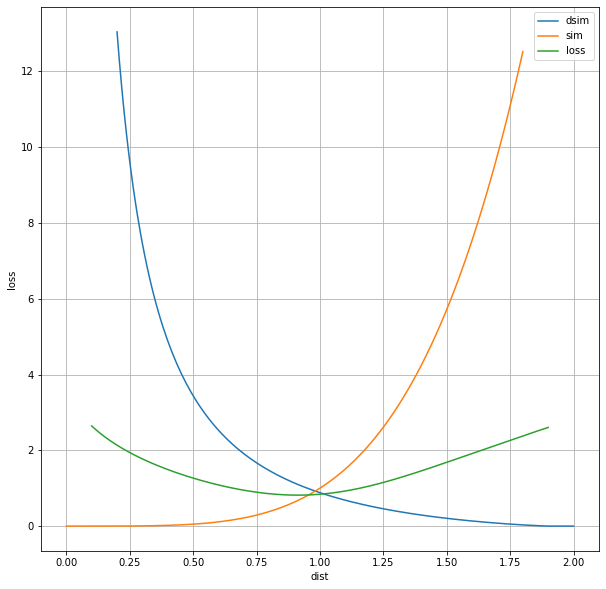

In [14]:
# Testing the loss function parameters
def test_params(sim_slink=4.3,dis_thresh=1.9,eps=1.2):
    c = 200

    s_mi, s_ma = 0, 1.8
    d_mi, d_ma = 0.2, 2
    sim = np.linspace(s_mi, s_ma, c)
    dsm = np.linspace(d_mi, d_ma, c)
    cen = np.linspace((d_mi+s_mi)/2,(d_ma+s_ma)/2,c)

    max_one = np.vectorize(lambda x: max(0,x))

    sim_loss = sim ** sim_slink
    dissim_loss = max_one(dis_thresh/dsm-1) ** eps
    loss = np.log(sim_loss + dissim_loss + 1.)

    plt.figure(figsize=(10,10))
    plt.plot(dsm,dissim_loss,label="dsim")
    plt.plot(sim,sim_loss,label="sim")
    plt.plot(cen, loss, label="loss")
    plt.xlabel('dist')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()

    print(loss.max())
    plt.show()

test_params()

___

# 3. Fit Functions

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 3.1 Standard fit function
Uses a standard loss function (class based)

In [16]:
def std_fit(model, optim, loss_func, train_dl, valid_dl, epochs=25, data_count=None):
    start = time()
    time_st = lambda x: f"{x//60:0.0f} m {x%60:0.3f} s"
    model = model.to(device)
    losses_tr = []
    losses_va = []
    
    tr = 'train'
    va = 'valid'
    data = {tr:train_dl, va: valid_dl}
    
    if data_count is None:
        data_count = {tr: len(train_dl.dataset), va: len(valid_dl.dataset)}
        
    print(f"train samples: {data_count[tr]}, valid samples: {data_count[va]}")
    best_accu = 0.0
    least_loss = 20
    best_model_state_dict = model.state_dict()
    
    # Add timer
    for epoch in range(epochs): 
        e_start = time()
        
        print(f"\nEPOCH: ({epoch + 1}/{epochs})\t{e_start - start:0.3f} s\n","-"*20) 
        for phase in [tr, va]:
            p_start = time()
            
            is_tr = phase == tr
            is_va = phase == va
            
            if is_tr:
                model.train()
            else:
                model.eval()
             
            """
            Loss and accuracy calculated 
            during a single epoch.
            """
            running_loss = 0.
            running_accu = 0
            
            for batch in data[phase]:
                X, y = batch
                X = X.to(device)
                y = y.to(device)
                
                optim.zero_grad()
                
                with torch.set_grad_enabled(is_tr):  
                    y_val = model(X)
                    y_cls = torch.argmax(y_val, dim=1)
                
                    loss = loss_func(y_val, y)
                
                    if is_tr:
                        loss.backward()
                        optim.step()
                
                """
                Running Loss:
                    Loss calculated over the entire dataset,
                    for one epoch. Loss for an epoch will be 
                    running loss divided by the total number
                    of samples (not batches).
                Running Accuracy:
                    Number of samples the model got right.
                    
                """
                samp_loss = loss.item() * len(y)
                if is_tr:
                    losses_tr.append(samp_loss)
                else:
                    losses_va.append(samp_loss)
                    
                running_loss += samp_loss
                running_accu += torch.sum(y_cls == y).item()
            
            p_time = time() - p_start
            epoch_loss = running_loss / data_count[phase]
            epoch_accu = running_accu / data_count[phase]
            print(f"{phase}: loss {epoch_loss:0.3f}, accu {epoch_accu:0.3f}, time {time_st(p_time)}")
            
            if is_va and (epoch_accu > best_accu) or (epoch_accu == best_accu and least_loss > epoch_loss):
                best_accu = epoch_accu
                least_loss = epoch_loss
                best_model_state_dict = deepcopy(model.state_dict())
            elif is_va and least_loss > epoch_loss:
                least_loss = epoch_loss                           
     
    tot_time = time() - start
    print(f"\nTime taken: {time_st(tot_time)}, Best accuracy: {best_accu:0.3f}") 
    return model.load_state_dict(best_model_state_dict), losses_tr, losses_va

## 3.2 Fit Function for Distance based loss
Uses the custom distance based loss function

In [17]:
def dist_fit(model, optim, loss_func, train_dl, valid_dl=None, epochs=25, data_count=None):
    start = time()
    time_st = lambda x: f"{x//60:0.0f} m {x%60:0.3f} s"
    model = model.to(device)
    losses_tr = []
    losses_va = []
    valid_is_none = valid_dl is None
    
    # Define datasets dict
    tr = 'train'
    va = 'valid'
    sets = [tr,va]
    if valid_is_none:
        sets = [tr]
    data = {tr:train_dl, va: valid_dl}
    
    # Define datacount dict and printing number of samples.
    if data_count is None:
        data_count = {}
        if not valid_is_none:
            data_count = {tr: len(train_dl.dataset), va: len(valid_dl.dataset)}
            print(f"train samples: {data_count[tr]}, valid samples: {data_count[va]}")
        else:
            data_count = {tr: len(train_dl.dataset)}
            print(f"samples: {data_count[tr]}")
    else:
        if not valid_is_none:
            print(f"train samples: {data_count[tr]}, valid samples: {data_count[va]}")
        else:
            print(f"samples: {data_count[tr]}")
            
        
        
    least_loss = torch.tensor(float('inf'))
    best_model_state_dict = deepcopy(model.state_dict())
    
    # Add timer
    for epoch in range(epochs): 
        e_start = time()
        
        print(f"\nEPOCH: ({epoch + 1}/{epochs})\t{e_start - start:0.3f} s\n","-"*20) 
        for phase in sets:
            p_start = time()
            
            is_tr = phase == tr
            if is_tr:
                model.train()
            else:
                model.eval()
             
            running_loss = 0.
            
            for batch in data[phase]:
                X, y = batch
                X = X.to(device)
                y = y.to(device)
                
                optim.zero_grad()
                
                with torch.set_grad_enabled(is_tr):  
                    y_vectors = model(X)
                
                    loss = loss_func(y_vectors, y)
                
                    if is_tr:
                        loss.backward()
                        optim.step()
                
                samp_loss = loss * len(y)
                if is_tr:
                    losses_tr.append(samp_loss)
                else:
                    losses_va.append(samp_loss)
                running_loss += samp_loss
            
            p_time = time() - p_start
            epoch_loss = running_loss / data_count[phase]
            print(f"{phase}: loss {epoch_loss:0.3f}, time {time_st(p_time)}")
            
            if (not is_tr) and (least_loss > epoch_loss):
                least_loss = epoch_loss
                best_model_state_dict = deepcopy(model.state_dict())
            elif valid_is_none and (least_loss > epoch_loss):
                least_loss = epoch_loss
                best_model_state_dict = deepcopy(model.state_dict())
                
     
    tot_time = time() - start
    print(f"\nTime taken: {time_st(tot_time)}") 
    return model.load_state_dict(best_model_state_dict), losses_tr, losses_va

## 3.3 Function to plot the losses

In [18]:
def plot_losses(losses_tr,losses_va,count,l1="training loss",l2="validation loss"):
    s_tr = len(losses_tr)//count
    s_va = len(losses_va)//count
    
    
    tr_y = losses_tr[::s_tr]
    tr_x = np.arange(len(tr_y))
    
    va_y = losses_va[::s_va]
    va_x = np.arange(len(va_y))
    
    plt.figure(figsize=(20,10))
    
    plt.plot(tr_x, tr_y, label=l1)
    plt.plot(va_x, va_y, label=l2)
    
    plt.title("Iteration vs Loss")
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

___

# 4. Functions to plot some metrics

Function that gets all the vector representation of samples in a dataset along with labels

In [19]:
def get_repr(data_set, model):
    vec_repr = []
    vec_labl = []

    model.eval()
    with torch.no_grad():
        for sample in data_set:
            X, y = sample
            vec_repr.append(model(X.reshape(-1,3,160,160)))
            vec_labl.append(y)

    vec_repr = torch.cat(vec_repr)
    return vec_repr, vec_labl

Function to calculate distance between two sets of vectors.

In [20]:
def get_cross_dist(vec_repr_1, vec_repr_2, dist_calc=nn.PairwiseDistance(p=2,eps=0)):
    vec_cross_dist = []
    for vec in vec_repr_1:
        vec_cross_dist.append(dist_calc(vec_repr_2,vec))
    return torch.stack(vec_cross_dist) 

## 4.1 Displaying the distances for similar and dissimilar classes
The max distance here will be sort of the upper limit for identification ie if the distance is above this max then identification will take place.

In [21]:
def show_min_max(vec_cross_dist, vec_labl_1, vec_labl_2, show_sim=True, show_per_class=False, show_scores=False):
    if show_sim:
        print("SHOWING SIMILAR")
    else:
        print("SHOWING DISSIMILAR")
    max_dist = []
    min_dist = []
    log_dist = []
    for i,vec in enumerate(vec_cross_dist):
        if show_per_class:
            print(f"class {vec_labl_1[i]}:",end="\t")
        dists = []
        for j,dist in enumerate(vec):
            if show_scores and show_per_class:
                print(f"{dist:0.1f} ",end=" ")
            if vec_labl_1[i] == vec_labl_2[j] and i != j and show_sim:
                log_dist.append(dist)
                dists.append(dist)
            elif not show_sim and vec_labl_1[i] != vec_labl_2[j]:
                log_dist.append(dist)
                dists.append(dist)

        if len(dists) > 0:
            mx = max(dists)
            mn = min(dists)
            max_dist.append(mx)
            min_dist.append(mn)
            if show_per_class:
                d = ""
                if show_scores:
                    d = "\n\t\t"
                print(f"{d}max: {mx:0.2f}",end="\t") 
                print(f"min: {mn:0.2f}{d}") 

    print('---')
    print(f"alltime max(max) = {max(max_dist)}")
    print(f"alltime min(max) = {min(max_dist)}")
    print(f"mean of max      = {torch.tensor(max_dist).mean()}")
    print()
    print(f"alltime min(min) = {min(min_dist)}")
    print(f"alltime max(min) = {max(min_dist)}")
    print(f"mean of min      = {torch.tensor(min_dist).mean()}")
    print()
    print(f"overall mean     = {torch.tensor(log_dist).mean()}")
    print()

In [22]:
def show_dist_model_stats(model,data_set,show_both=True, show_per_class=False, show_scores=False):
    vec_repr = get_repr(data_set,model)
    dist_matr = get_cross_dist(vec_repr[0],vec_repr[0])
    if show_both:
        show_min_max(dist_matr,vec_repr[1],vec_repr[1],show_sim=True,show_per_class=show_per_class,show_scores=show_scores)
        print('---')
    show_min_max(dist_matr,vec_repr[1],vec_repr[1],show_sim=False,show_per_class=show_per_class,show_scores=show_scores)

___

# 5. Altering the model features

In [24]:
# Calculating the weight (due to unbalanced dataset)
weight = []
l = len(data_set_all)
for i,_ in enumerate(data_set_all.classes):
     weight.append(1/np.count_nonzero(np.array(data_set_all.targets) == i))
weight = torch.tensor(weight)

## 5.1 Model 1: Training using the softmax layer 
- Attaching a linear layer (512 to number of classes) and then a softmax layer on that
- Freezing all the layers but the last linear layer (output size 512)
- Training on this then removing the new linear layer and softmax layer and using what is left for embedding generation
- Loss is calculated using CrossEntropyLoss

In [31]:
inception_resnet_v1 = InceptionResnetV1()
in_features = inception_resnet_v1.last_linear.out_features
out_features = len(data_set_all.classes)

for param in inception_resnet_v1.parameters():
    param.requires_grad = False
    
for param in inception_resnet_v1.last_linear.parameters():
    param.requires_grad = True
    
model = nn.Sequential(
    inception_resnet_v1,
    nn.Linear(in_features, out_features),
    nn.LogSoftmax(dim=1)
)

params = list(model[0].last_linear.parameters()) + list(model[1].parameters())
optim = torch.optim.Adam(params,lr=0.0005)
loss_func = nn.CrossEntropyLoss(weight)

### 5.1.1 Training the model (model 1)
(Just the last linear layer, everything else is locked)

In [32]:
_, losses_tr_1, losses_va_1 = std_fit(model, optim, loss_func, dataloaders[tr], dataloaders[va],data_count=data_count,epochs=40)

# Copy model to a variable.
model_1 = model[0]
model_1_state_dict = model[0].state_dict().copy()

train samples: 83, valid samples: 21

EPOCH: (1/40)	0.009 s
 --------------------
train: loss 1.245, accu 0.675, time 0 m 6.102 s
valid: loss 1.133, accu 0.667, time 0 m 1.074 s

EPOCH: (2/40)	7.240 s
 --------------------
train: loss 1.068, accu 0.855, time 0 m 6.605 s
valid: loss 0.979, accu 0.810, time 0 m 1.049 s

EPOCH: (3/40)	14.959 s
 --------------------
train: loss 1.005, accu 0.819, time 0 m 5.932 s
valid: loss 0.912, accu 0.857, time 0 m 1.046 s

EPOCH: (4/40)	22.001 s
 --------------------
train: loss 0.906, accu 0.855, time 0 m 5.872 s
valid: loss 0.846, accu 0.857, time 0 m 1.051 s

EPOCH: (5/40)	28.988 s
 --------------------
train: loss 0.870, accu 0.819, time 0 m 6.104 s
valid: loss 0.872, accu 0.714, time 0 m 1.318 s

EPOCH: (6/40)	36.411 s
 --------------------
train: loss 0.755, accu 0.904, time 0 m 6.808 s
valid: loss 0.742, accu 0.810, time 0 m 1.130 s

EPOCH: (7/40)	44.351 s
 --------------------
train: loss 0.748, accu 0.867, time 0 m 6.205 s
valid: loss 0.717, 

### 5.1.2 Plotting the losses (model 1)

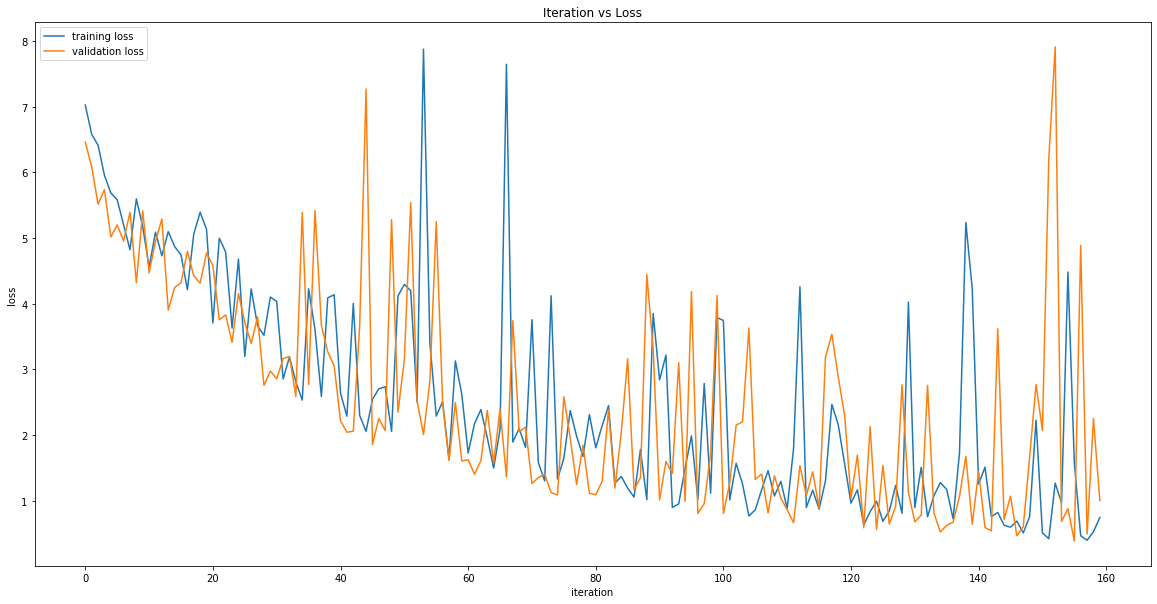

In [33]:
plot_losses(losses_tr_1, losses_va_1, count=len(losses_va_1))

### 5.1.3 Embedding metrics (model 1)

In [34]:
show_dist_model_stats(model_1,data_set_test)

SHOWING SIMILAR
---
alltime max(max) = 1.6025304794311523
alltime min(max) = 0.2081892341375351
mean of max      = 1.0280370712280273

alltime min(min) = 0.14943930506706238
alltime max(min) = 1.2132316827774048
mean of min      = 0.38873228430747986

overall mean     = 0.6758748888969421

---
SHOWING DISSIMILAR
---
alltime max(max) = 1.9533334970474243
alltime min(max) = 1.7727091312408447
mean of max      = 1.8878329992294312

alltime min(min) = 0.6961373090744019
alltime max(min) = 1.3985594511032104
mean of min      = 1.1630741357803345

overall mean     = 1.587152123451233



### 5.1.4 Doing all the same things but with the augmented data.

train samples: 819, valid samples: 205

EPOCH: (1/10)	0.005 s
 --------------------
train: loss 1.021, accu 0.789, time 0 m 55.038 s
valid: loss 0.732, accu 0.922, time 0 m 10.431 s

EPOCH: (2/10)	65.532 s
 --------------------
train: loss 0.670, accu 0.878, time 0 m 57.510 s
valid: loss 0.734, accu 0.717, time 0 m 10.960 s

EPOCH: (3/10)	134.002 s
 --------------------
train: loss 0.484, accu 0.884, time 0 m 57.102 s
valid: loss 0.361, accu 0.907, time 0 m 12.272 s

EPOCH: (4/10)	203.377 s
 --------------------
train: loss 0.413, accu 0.890, time 1 m 3.421 s
valid: loss 0.289, accu 0.922, time 0 m 10.422 s

EPOCH: (5/10)	277.287 s
 --------------------
train: loss 0.345, accu 0.899, time 0 m 51.181 s
valid: loss 0.233, accu 0.922, time 0 m 9.900 s

EPOCH: (6/10)	338.430 s
 --------------------
train: loss 0.306, accu 0.899, time 0 m 51.250 s
valid: loss 0.181, accu 0.922, time 0 m 9.925 s

EPOCH: (7/10)	399.668 s
 --------------------
train: loss 0.281, accu 0.907, time 0 m 51.496 s
v

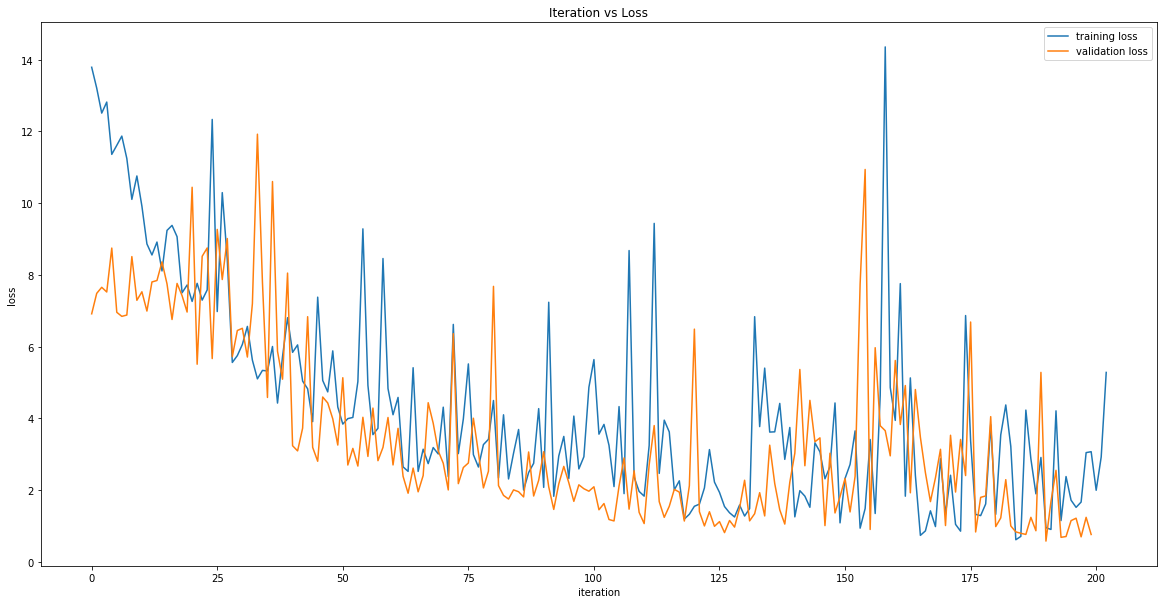

SHOWING SIMILAR
---
alltime max(max) = 1.9515575170516968
alltime min(max) = 0.7868174910545349
mean of max      = 1.6203125715255737

alltime min(min) = 0.02533506415784359
alltime max(min) = 1.0203546285629272
mean of min      = 0.3493935465812683

overall mean     = 0.986936092376709

---
SHOWING DISSIMILAR
---
alltime max(max) = 1.9673033952713013
alltime min(max) = 1.565977931022644
mean of max      = 1.8787469863891602

alltime min(min) = 0.39875683188438416
alltime max(min) = 1.188030481338501
mean of min      = 0.7366311550140381

overall mean     = 1.4761316776275635



In [35]:
# Calculating the weight (due to unbalanced dataset).
weight_aug = []
l = len(data_set_all_aug)
for i,_ in enumerate(data_set_all_aug.classes):
     weight_aug.append(1/np.count_nonzero(np.array(data_set_all_aug.targets) == i))
        
weight_aug = torch.tensor(weight_aug)

# Initialise model parameters.
inception_resnet_v1_aug = InceptionResnetV1()
in_features = inception_resnet_v1_aug.last_linear.out_features
out_features = len(data_set_all_aug.classes)

for param in inception_resnet_v1_aug.parameters():
    param.requires_grad = False
    
for param in inception_resnet_v1_aug.last_linear.parameters():
    param.requires_grad = True
    
model_aug = nn.Sequential(
    inception_resnet_v1_aug,
    nn.Linear(in_features, out_features),
    nn.LogSoftmax(dim=1)
)

params = list(model_aug[0].last_linear.parameters()) + list(model_aug[1].parameters())
optim = torch.optim.Adam(params,lr=0.0005)
loss_func = nn.CrossEntropyLoss(weight_aug)

# Call fit on the model.
_, losses_tr_1_aug, losses_va_1_aug = std_fit(model_aug, optim, loss_func, dataloaders_aug[tr],
                                              dataloaders_aug[va],data_count=data_count_aug, epochs=10)

# Copy model to a variable.
model_1_aug = model[0]
model_1_state_dict_aug = model[0].state_dict().copy()

# Plotting the losses.
plot_losses(losses_tr_1_aug, losses_va_1_aug, count=len(losses_va_1_aug))

# Show the model stats.
show_dist_model_stats(model_1_aug,data_set_test_aug)

___

## 5.2 Model 2: Training without the softmax layer
- Freezing all the layers but the last linear layer (output size 512)
- Loss is calculated using the custom loss function

In [36]:
model_2 = InceptionResnetV1()

for param in model_2.parameters():
    param.requires_grad = False
    
for param in model_2.last_linear.parameters():
    param.requires_grad = True
    

optim = torch.optim.Adam(params=model_2.last_linear.parameters(),lr=0.0005)
loss_func = DistLoss()

### 5.2.1 Training the model (model 2)
(Just the last linear layer, everything else is locked)

In [37]:
_, losses_tr_2, losses_va_2 = dist_fit(model_2, optim, loss_func, dataloaders[tr], dataloaders[va],data_count=data_count,epochs=40)

train samples: 83, valid samples: 21

EPOCH: (1/40)	0.056 s
 --------------------
train: loss 2.635, time 0 m 6.131 s
valid: loss 0.856, time 0 m 1.068 s

EPOCH: (2/40)	7.319 s
 --------------------
train: loss 1.625, time 0 m 5.952 s
valid: loss 0.836, time 0 m 1.042 s

EPOCH: (3/40)	14.376 s
 --------------------
train: loss 1.366, time 0 m 5.931 s
valid: loss 0.779, time 0 m 1.051 s

EPOCH: (4/40)	21.420 s
 --------------------
train: loss 1.058, time 0 m 5.920 s
valid: loss 1.121, time 0 m 1.039 s

EPOCH: (5/40)	28.380 s
 --------------------
train: loss 0.935, time 0 m 5.918 s
valid: loss 0.875, time 0 m 1.037 s

EPOCH: (6/40)	35.336 s
 --------------------
train: loss 0.970, time 0 m 5.902 s
valid: loss 0.824, time 0 m 1.057 s

EPOCH: (7/40)	42.296 s
 --------------------
train: loss 0.874, time 0 m 5.902 s
valid: loss 1.475, time 0 m 1.041 s

EPOCH: (8/40)	49.239 s
 --------------------
train: loss 0.577, time 0 m 5.893 s
valid: loss 0.474, time 0 m 1.037 s

EPOCH: (9/40)	56.232

In [38]:
# Copy model to a variable.
model_2_state_dict = model_2.state_dict().copy()

### 5.2.2 Plotting the losses (model 2)

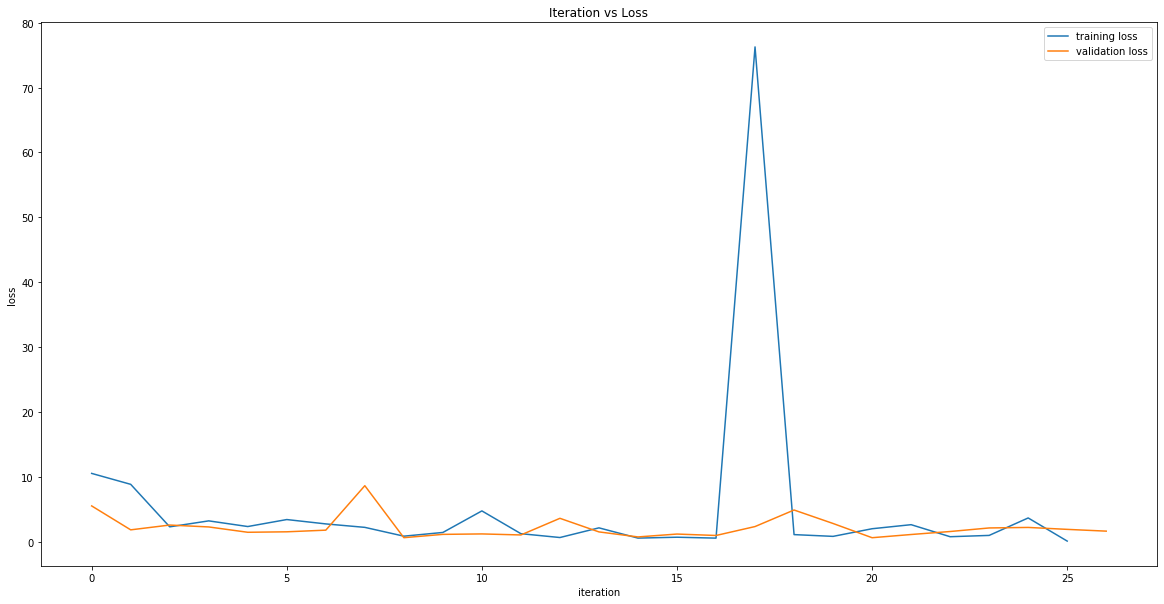

In [39]:
plot_losses(losses_tr_2, losses_va_2, count=25)

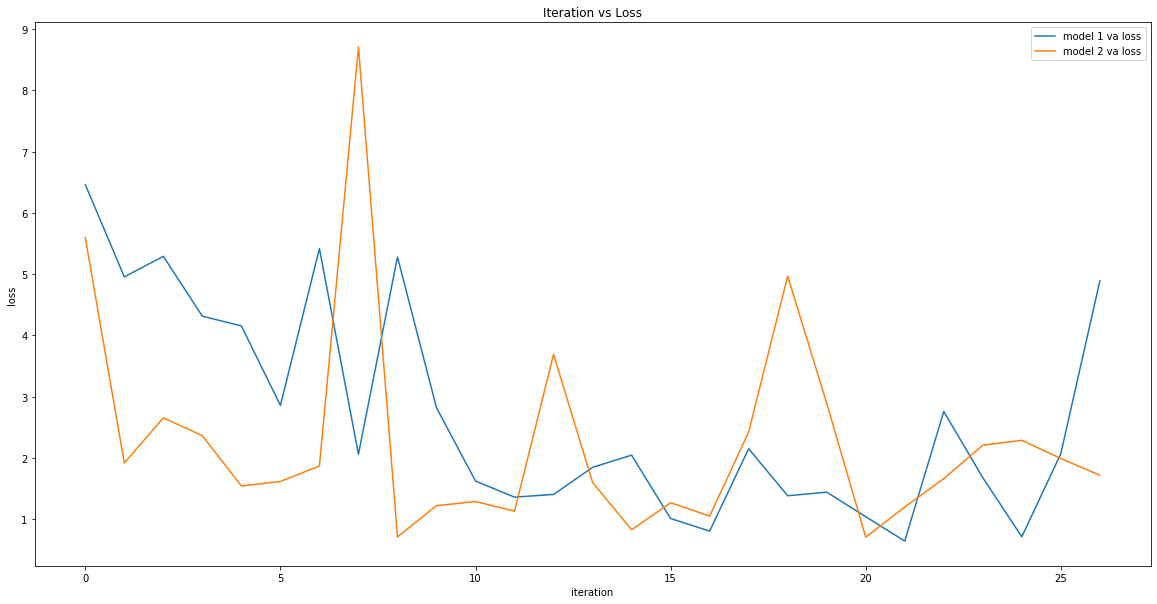

In [40]:
# Comparing loss calculation for the two different loss functions
plot_losses(losses_va_1,losses_va_2, count=25, l1="model 1 va loss", l2="model 2 va loss")

### 5.2.3 Embedding metrics (model 2)

In [41]:
show_dist_model_stats(model_2,data_set_test)

SHOWING SIMILAR
---
alltime max(max) = 1.8590360879898071
alltime min(max) = 0.16494593024253845
mean of max      = 0.942518413066864

alltime min(min) = 0.09835799038410187
alltime max(min) = 1.5975126028060913
mean of min      = 0.22294782102108002

overall mean     = 0.46351754665374756

---
SHOWING DISSIMILAR
---
alltime max(max) = 1.9804338216781616
alltime min(max) = 1.7124462127685547
mean of max      = 1.9407657384872437

alltime min(min) = 0.6562591791152954
alltime max(min) = 1.3751264810562134
mean of min      = 0.9216481447219849

overall mean     = 1.5889021158218384



### 5.2.4 Doing all the same things but with the augmented data. (model 2)

train samples: 819, valid samples: 205

EPOCH: (1/10)	0.054 s
 --------------------
train: loss 1.133, time 0 m 52.742 s
valid: loss 0.605, time 0 m 10.115 s

EPOCH: (2/10)	62.975 s
 --------------------
train: loss 0.589, time 0 m 51.644 s
valid: loss 0.393, time 0 m 11.878 s

EPOCH: (3/10)	126.638 s
 --------------------
train: loss 0.431, time 1 m 1.805 s
valid: loss 0.354, time 0 m 12.632 s

EPOCH: (4/10)	201.148 s
 --------------------
train: loss 0.396, time 1 m 1.265 s
valid: loss 0.306, time 0 m 12.036 s

EPOCH: (5/10)	274.525 s
 --------------------
train: loss 0.389, time 1 m 0.872 s
valid: loss 0.343, time 0 m 12.176 s

EPOCH: (6/10)	347.575 s
 --------------------
train: loss 0.402, time 1 m 5.682 s
valid: loss 0.287, time 0 m 12.259 s

EPOCH: (7/10)	425.598 s
 --------------------
train: loss 0.370, time 1 m 2.793 s
valid: loss 0.337, time 0 m 12.310 s

EPOCH: (8/10)	500.702 s
 --------------------
train: loss 0.419, time 1 m 2.861 s
valid: loss 0.317, time 0 m 12.929 s

E

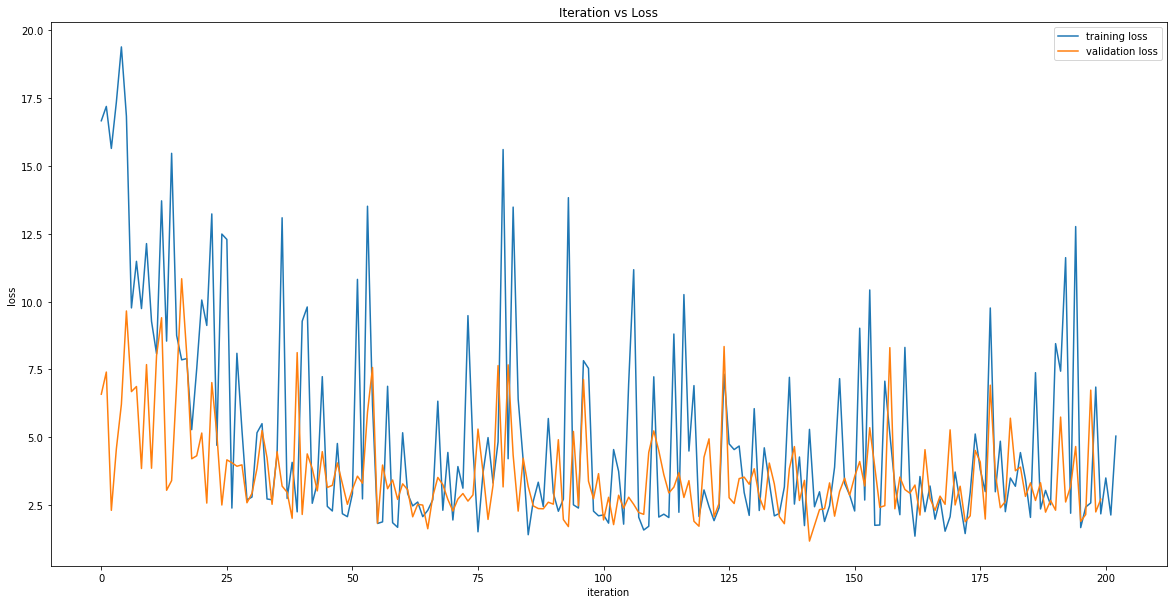

SHOWING SIMILAR
---
alltime max(max) = 1.9717644453048706
alltime min(max) = 0.3592413663864136
mean of max      = 1.639829158782959

alltime min(min) = 0.021375827491283417
alltime max(min) = 0.8144448399543762
mean of min      = 0.10914599895477295

overall mean     = 0.6060330271720886

---
SHOWING DISSIMILAR
---
alltime max(max) = 1.9985066652297974
alltime min(max) = 1.847809910774231
mean of max      = 1.9845001697540283

alltime min(min) = 0.11493893712759018
alltime max(min) = 1.250746726989746
mean of min      = 0.5650266408920288

overall mean     = 1.5621479749679565



In [42]:
# Initialise model parameters.
model_2_aug = InceptionResnetV1()

for param in model_2_aug.parameters():
    param.requires_grad = False
    
for param in model_2_aug.last_linear.parameters():
    param.requires_grad = True
    

optim = torch.optim.Adam(params=model_2_aug.last_linear.parameters(),lr=0.0005)
loss_func = DistLoss()

# Call fit on the model.
_, losses_tr_2_aug, losses_va_2_aug = dist_fit(model_2_aug, optim, loss_func, dataloaders_aug[tr],
                                              dataloaders_aug[va],data_count=data_count_aug, epochs=10)

# Copy model to a variable.
model_2_state_dict_aug = model_2_aug.state_dict().copy()

# Plotting the losses.
plot_losses(losses_tr_2_aug, losses_va_2_aug, count=len(losses_va_2_aug))

# Show the model stats.
show_dist_model_stats(model_2_aug,data_set_test_aug)

## Conclusion
- The custom loss function gives a more extreme model evident from the stats
- Need to retrain while checking other parameters of the loss function.

# 6. Checking model 2 out with different custom loss parameters

2.990502622736859


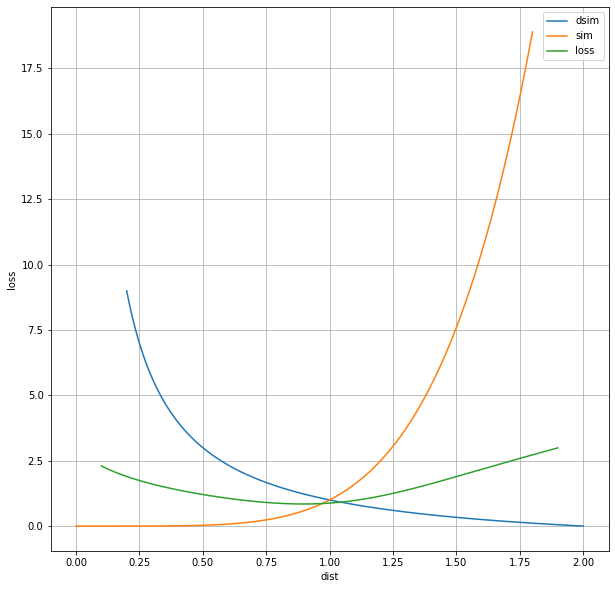

In [709]:
test_params(5,2,1)

## 6.1 Defining different set of params

In [712]:
"""
Default values:
    sim_slink=4.3
    dis_thresh=1.9
    eps=1.2
    
dis_thresh:
    the value to which max mean dist should tend to.
    beyond this value dis_loss will be < rsm.
sim_slink:
    growth of sim_loss (less than one slower than linear).
eps:
    the power dis_loss is raised to.
    
"""

custom_loss_functions = [
    DistLoss(),
    
    DistLoss(eps=0.8),
    DistLoss(eps=1.0),
    DistLoss(eps=2.0),
    
    DistLoss(sim_slink=2.0,dis_thresh=1.95,eps=0.4),
    DistLoss(sim_slink=3.0,dis_thresh=3.0,eps=1.5),
    DistLoss(sim_slink=5.0,dis_thresh=2.0,eps=1.0),
]

## 6.2 Calling fit using the different loss functions

In [713]:
models = []
losses = []

for i,loss_func in enumerate(custom_loss_functions):
    print(f"#{i} {'_'*47}")
    
    # Model Initialization
    model = InceptionResnetV1()
    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False
    # Thaw last layer
    for param in model.last_linear.parameters():
        param.requires_grad = True
    optim = torch.optim.Adam(params=model.last_linear.parameters())
    # Train
    _, losses_tr, losses_va = dist_fit(model, optim, loss_func, dataloaders[tr], dataloaders[va],data_count=data_count)
    
    # Save model and losses
    models.append(model.state_dict().copy())
    losses.append((losses_tr, losses_va))

#0 _______________________________________________
train samples: 102, valid samples: 26

EPOCH: (1/25)	0.086 s
 --------------------
train: loss 1.686, time 0 m 7.728 s
valid: loss 0.431, time 0 m 1.452 s

EPOCH: (2/25)	9.342 s
 --------------------
train: loss 1.182, time 0 m 7.911 s
valid: loss 0.432, time 0 m 1.310 s

EPOCH: (3/25)	18.564 s
 --------------------
train: loss 0.657, time 0 m 7.323 s
valid: loss 4.603, time 0 m 1.298 s

EPOCH: (4/25)	27.186 s
 --------------------
train: loss 0.665, time 0 m 7.300 s
valid: loss 0.310, time 0 m 1.283 s

EPOCH: (5/25)	35.832 s
 --------------------
train: loss 0.552, time 0 m 7.293 s
valid: loss 0.264, time 0 m 1.293 s

EPOCH: (6/25)	44.482 s
 --------------------
train: loss 0.759, time 0 m 7.304 s
valid: loss 0.129, time 0 m 1.293 s

EPOCH: (7/25)	53.143 s
 --------------------
train: loss 0.403, time 0 m 7.269 s
valid: loss 0.451, time 0 m 1.284 s

EPOCH: (8/25)	61.697 s
 --------------------
train: loss 0.357, time 0 m 7.282 s
valid

train: loss 1.309, time 0 m 7.442 s
valid: loss 0.129, time 0 m 1.321 s

EPOCH: (18/25)	149.696 s
 --------------------
train: loss 1.350, time 0 m 7.433 s
valid: loss 0.097, time 0 m 1.303 s

EPOCH: (19/25)	158.499 s
 --------------------
train: loss 0.454, time 0 m 7.415 s
valid: loss 0.131, time 0 m 1.304 s

EPOCH: (20/25)	167.219 s
 --------------------
train: loss 0.396, time 0 m 7.439 s
valid: loss 0.124, time 0 m 1.311 s

EPOCH: (21/25)	175.969 s
 --------------------
train: loss 2.233, time 0 m 7.419 s
valid: loss 0.114, time 0 m 1.303 s

EPOCH: (22/25)	184.693 s
 --------------------
train: loss 1.497, time 0 m 7.420 s
valid: loss 0.105, time 0 m 1.301 s

EPOCH: (23/25)	193.414 s
 --------------------
train: loss 0.333, time 0 m 7.416 s
valid: loss 0.139, time 0 m 1.314 s

EPOCH: (24/25)	202.145 s
 --------------------
train: loss 0.435, time 0 m 7.424 s
valid: loss 0.262, time 0 m 1.309 s

EPOCH: (25/25)	210.878 s
 --------------------
train: loss 0.284, time 0 m 7.394 s
vali

train: loss 0.698, time 0 m 8.346 s
valid: loss 0.544, time 0 m 1.555 s

EPOCH: (9/25)	80.700 s
 --------------------
train: loss 0.635, time 0 m 8.635 s
valid: loss 0.542, time 0 m 1.528 s

EPOCH: (10/25)	90.864 s
 --------------------
train: loss 0.774, time 0 m 8.685 s
valid: loss 0.510, time 0 m 1.971 s

EPOCH: (11/25)	101.521 s
 --------------------
train: loss 0.559, time 0 m 9.612 s
valid: loss 6.038, time 0 m 2.159 s

EPOCH: (12/25)	113.293 s
 --------------------
train: loss 0.860, time 0 m 9.661 s
valid: loss 6.070, time 0 m 1.565 s

EPOCH: (13/25)	124.521 s
 --------------------
train: loss 0.653, time 0 m 8.528 s
valid: loss 0.491, time 0 m 1.310 s

EPOCH: (14/25)	134.429 s
 --------------------
train: loss 0.639, time 0 m 7.408 s
valid: loss 0.678, time 0 m 1.299 s

EPOCH: (15/25)	143.137 s
 --------------------
train: loss 0.715, time 0 m 7.419 s
valid: loss 0.568, time 0 m 1.293 s

EPOCH: (16/25)	151.849 s
 --------------------
train: loss 0.660, time 0 m 7.409 s
valid: 

## 6.3 Showing the outcomes

In [714]:
for i,m in enumerate(models):
    lf = custom_loss_functions[i]
    print(f"# {i+1}. outcome of {lf.sim_slink} {lf.dis_thresh} {lf.eps}:")
    temp_mod = InceptionResnetV1()
    temp_mod.load_state_dict(m)
    show_dist_model_stats(temp_mod, data_set_test)
    print('_'*50,'\n')

# 1. outcome of 4.3 1.9 1.2:
SHOWING SIMILAR
---
alltime max(max) = 1.3158385753631592
alltime min(max) = 0.2597355544567108
mean of max      = 0.891688346862793

alltime min(min) = 0.09585204720497131
alltime max(min) = 0.924789309501648
mean of min      = 0.22393935918807983

overall mean     = 0.39096203446388245

---
SHOWING DISSIMILAR
---
alltime max(max) = 1.989984393119812
alltime min(max) = 1.878552794456482
mean of max      = 1.9560903310775757

alltime min(min) = 0.7807799577713013
alltime max(min) = 1.377669334411621
mean of min      = 1.046818733215332

overall mean     = 1.624468445777893

__________________________________________________ 

# 2. outcome of 4.3 1.9 0.8:
SHOWING SIMILAR
---
alltime max(max) = 1.3896106481552124
alltime min(max) = 0.26931893825531006
mean of max      = 0.786832869052887

alltime min(min) = 0.07094637304544449
alltime max(min) = 0.863258421421051
mean of min      = 0.1760096400976181

overall mean     = 0.36845991015434265

---
SHOWING DISSIM

## 6.4 Plotting the validation loss

outcome of 5.0 2.0 1.0:


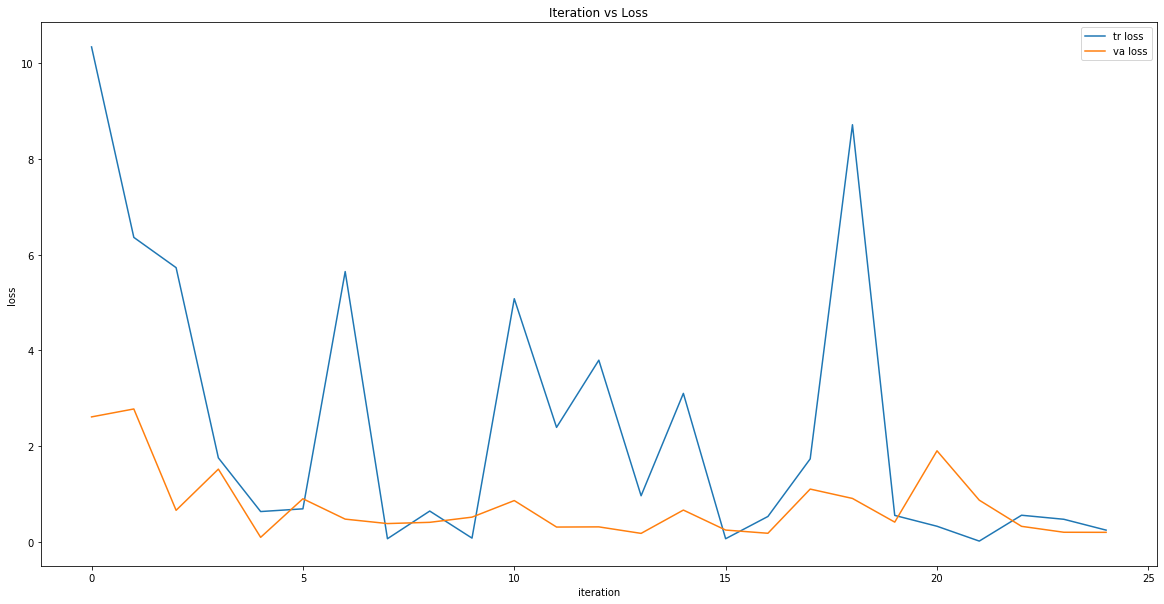

__________________________________________________ 

outcome of 5.0 2.0 1.0:


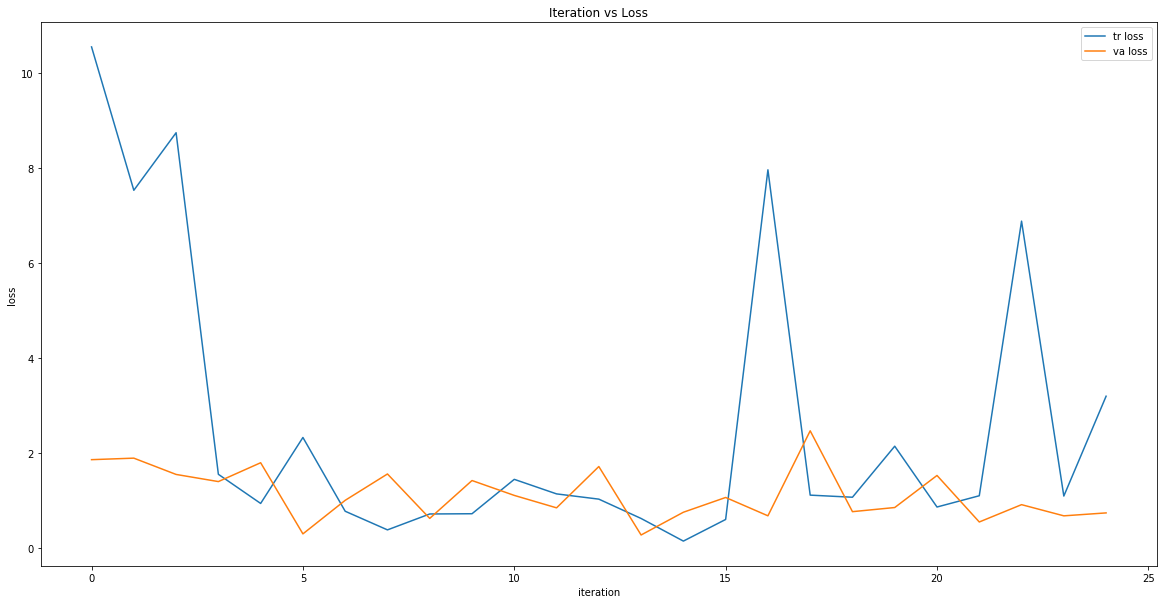

__________________________________________________ 

outcome of 5.0 2.0 1.0:


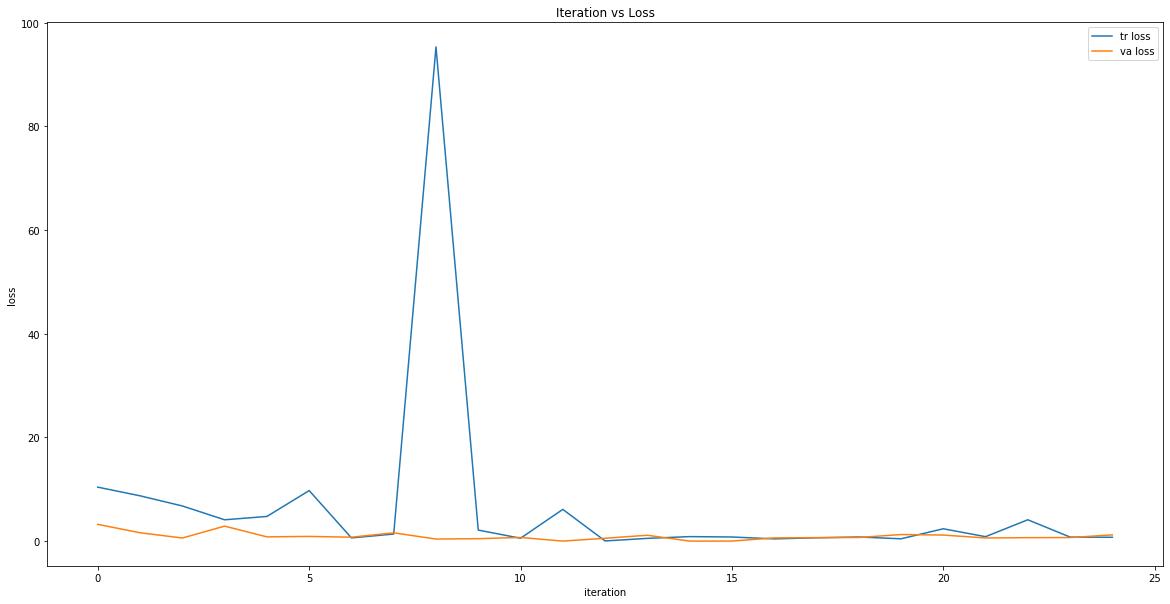

__________________________________________________ 

outcome of 5.0 2.0 1.0:


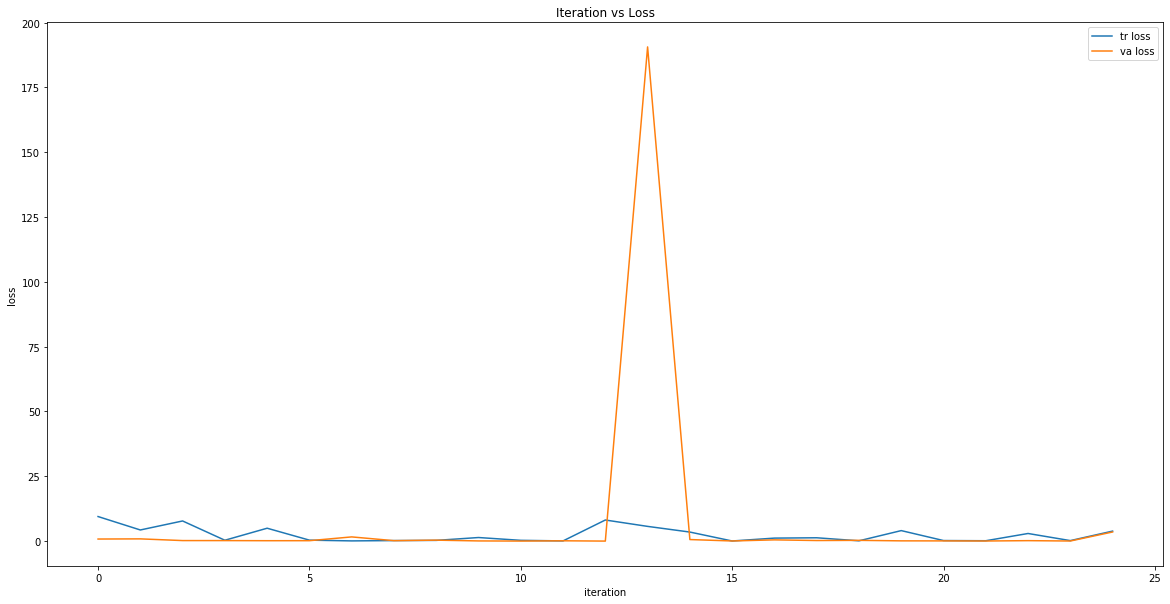

__________________________________________________ 

outcome of 5.0 2.0 1.0:


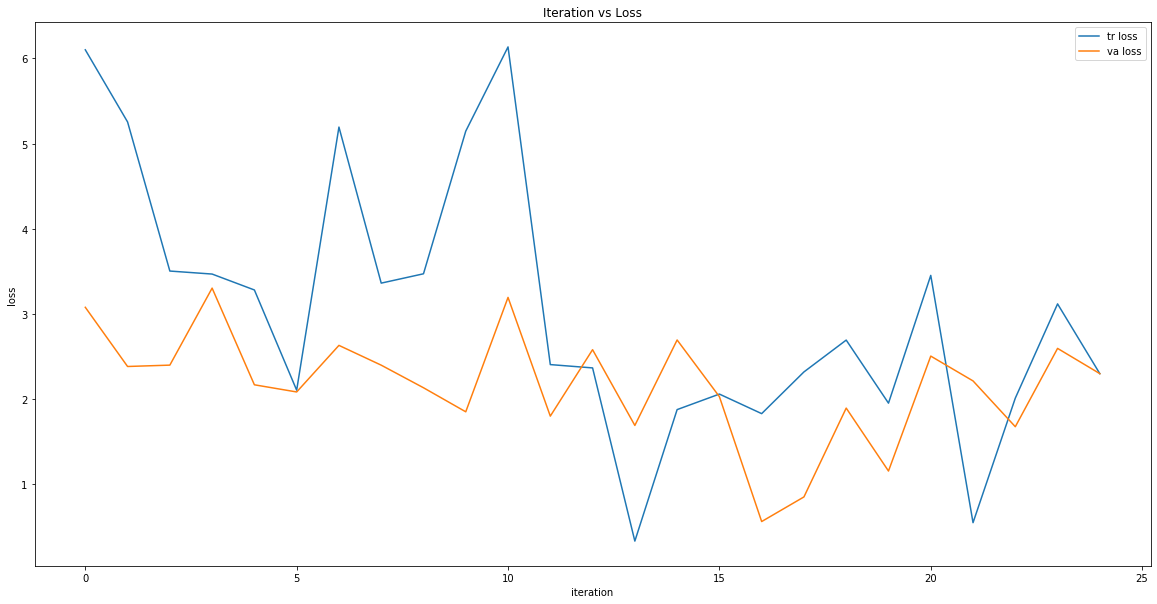

__________________________________________________ 

outcome of 5.0 2.0 1.0:


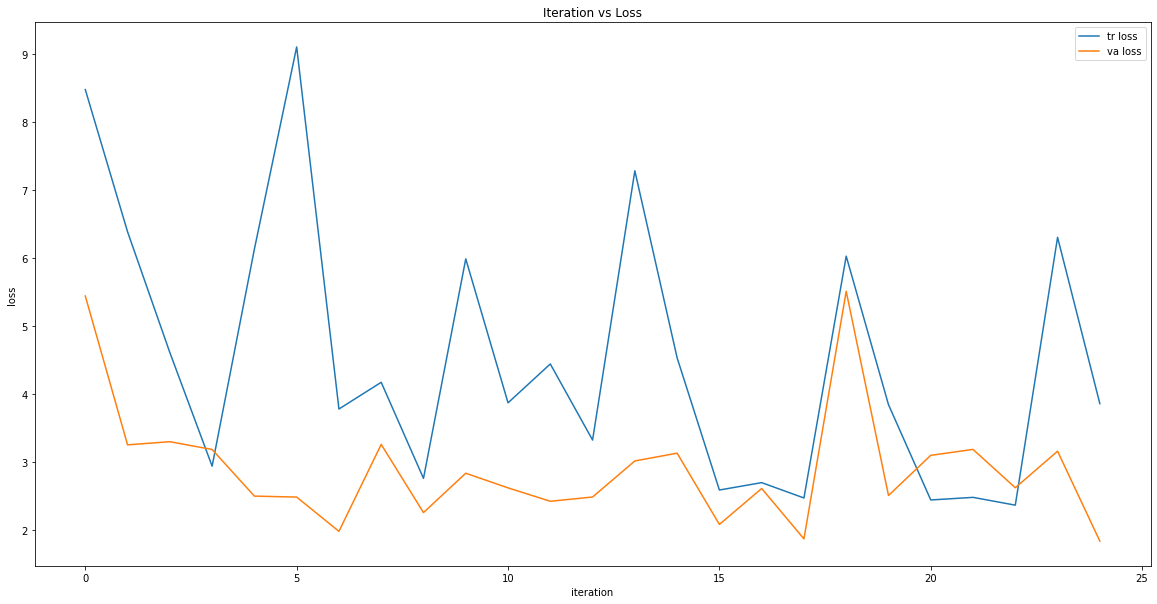

__________________________________________________ 

outcome of 5.0 2.0 1.0:


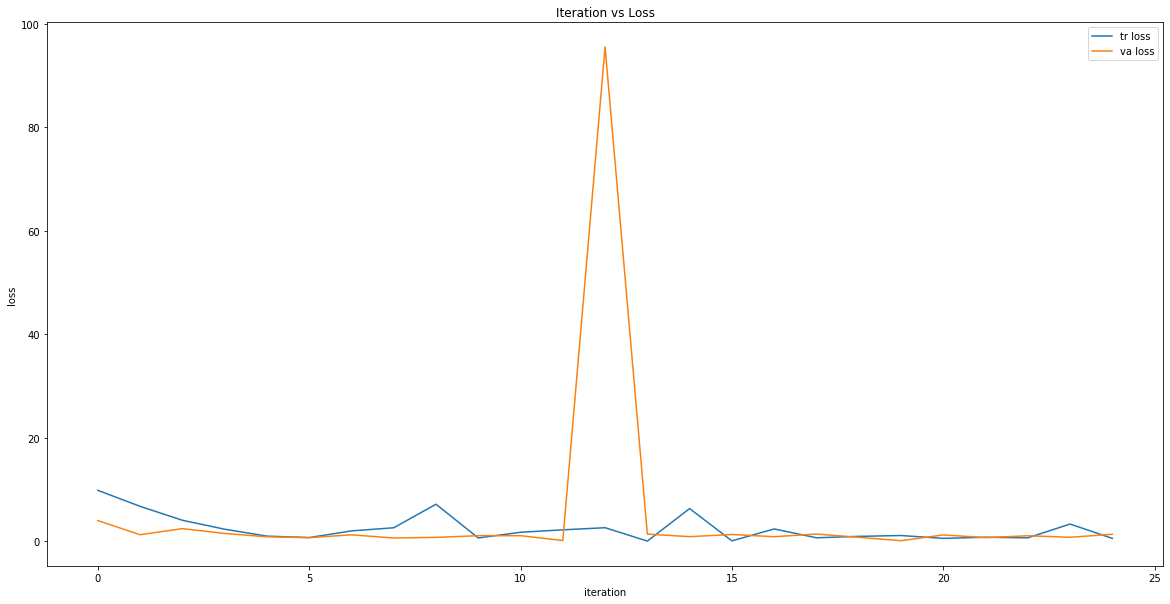

__________________________________________________ 



In [716]:
for i,l in enumerate(losses):
    print(f"outcome of {lf.sim_slink} {lf.dis_thresh} {lf.eps}:")
    plot_losses(l[0], l[1],count=25, l1="tr loss", l2="va loss")
    print('_'*50,'\n')

___

In [717]:
# Model Initialization
model = InceptionResnetV1()

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False
    
# Thaw last layer
for param in model.last_linear.parameters():
    param.requires_grad = True
optim = torch.optim.Adam(params=model.last_linear.parameters())
loss_func = DistLoss(eps=0.8)

# Train
_, losses_tr, losses_va = dist_fit(model, optim, loss_func, dataloaders[tr], dataloaders[va], data_count=data_count, epochs=40)


train samples: 102, valid samples: 26

EPOCH: (1/40)	0.068 s
 --------------------
train: loss 2.296, time 0 m 7.954 s
valid: loss 0.569, time 0 m 1.342 s

EPOCH: (2/40)	9.437 s
 --------------------
train: loss 0.993, time 0 m 7.389 s
valid: loss 0.335, time 0 m 1.311 s

EPOCH: (3/40)	18.202 s
 --------------------
train: loss 1.006, time 0 m 7.557 s
valid: loss 0.260, time 0 m 1.797 s

EPOCH: (4/40)	27.648 s
 --------------------
train: loss 2.146, time 0 m 7.672 s
valid: loss 0.324, time 0 m 1.386 s

EPOCH: (5/40)	36.707 s
 --------------------
train: loss 0.460, time 0 m 7.774 s
valid: loss 0.201, time 0 m 1.339 s

EPOCH: (6/40)	45.887 s
 --------------------
train: loss 1.453, time 0 m 7.400 s
valid: loss 0.243, time 0 m 1.356 s

EPOCH: (7/40)	54.643 s
 --------------------
train: loss 0.427, time 0 m 7.356 s
valid: loss 0.257, time 0 m 1.295 s

EPOCH: (8/40)	63.295 s
 --------------------
train: loss 0.595, time 0 m 7.426 s
valid: loss 0.205, time 0 m 1.326 s

EPOCH: (9/40)	72.04

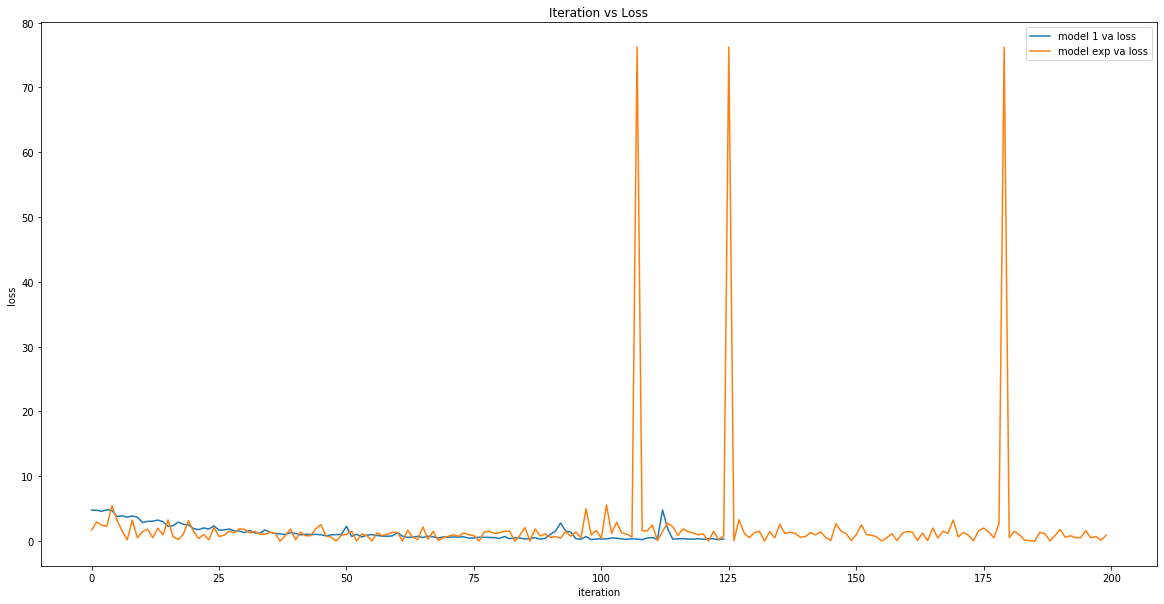

outcome of 4.3 1.9 0.8:
SHOWING SIMILAR
---
alltime max(max) = 1.1406503915786743
alltime min(max) = 0.21823076903820038
mean of max      = 0.6836387515068054

alltime min(min) = 0.05897930637001991
alltime max(min) = 0.6453923583030701
mean of min      = 0.15397308766841888

overall mean     = 0.3583934009075165

---
SHOWING DISSIMILAR
---
alltime max(max) = 1.9957002401351929
alltime min(max) = 1.8732209205627441
mean of max      = 1.963138461112976

alltime min(min) = 0.5362365245819092
alltime max(min) = 1.4755350351333618
mean of min      = 1.0433248281478882

overall mean     = 1.6290208101272583



In [718]:
plot_losses(losses_va_1, losses_va,count=125, l1="model 1 va loss", l2="model exp va loss")
print(f"outcome of {loss_func.sim_slink} {loss_func.dis_thresh} {loss_func.eps}:")
show_dist_model_stats(model,data_set_test)

## 6.4 Conclusion
- The decided upon criteria for a valid model is:  
  `mean of max SIMILAR < mean of min DISSIMILAR`
- Some of the models trained using DistLoss seem to to have a good gap between the two values under consideration.
- Deciding on these as the ideal parameters for DistLoss: 
    ```python
        sim_slink=4.3
        dis_thresh=1.9
        eps=0.8
    ```
- From the data the threshold decided is 0.7

___

# 7. Check accuracy of the model

- The model will calculate class using k-Nearest Neighbours
- Write script to train the model using data in some input folder (fine_tune.py).
- Raise warning if SIM mean of max > DISSIM mean of min.
- Set the threshold as SIM mean of max.

## 7.1 Helper functions
- `get_embeddings` to calculate embeddings from a dataset
- `predict` to predict the class of input crops

In [43]:
def get_embeddings(dataloader, model):
    """
    dataloader: pytorch DataLoader of n samples
    model: pytorch models used to generate embedding of shape (1,512).
    
    return: 
        embeds: tensor, shape (n,512)
        labels: int tensor, shape (n)
    """
    embeds = []
    labels = []
    model.eval()
    for d in dataloader:
        labels.append(d[1])
        with torch.no_grad():
            embeds.append(model(d[0]))
    return torch.cat(embeds),torch.cat(labels)


def predict(crops,embeds,labels,model,k=7,threshold=0.7):
    """
    crops: tensors, shape (m, 3, 160, 160).
    embeds: tensors, shape (n, 512).
    labels: int tensors, shape (n).
    model: pytorch models used to generate embedding of shape (1,512).
    k: neighbour classes to check.
    threshold: distance more than this is invalid
    
    return: int tensor, shape (m)
    """
    assert crops.shape[1] == 3, "invalid input shape"
    
    inf = torch.tensor(float('inf'))
    classes = []
    model.eval()
    with torch.no_grad():
        for crop in crops: 
            dists = torch.norm(embeds-model(crop.reshape(1,*crop.shape)),dim=1)
            knn = torch.topk(dists,k,largest=False)
            mask = dists[knn.indices] <= threshold
            # Indices of distances below threshold
            indices = knn.indices[mask]
            k_classes = labels[indices]
            try:
                classes.append(stats.mode(k_classes).mode[0])
            except IndexError:
                classes.append(-1)
    return torch.tensor(classes)

In [44]:
def test_accuracy(dataloader, embeds, labels, model, k=7, thresh=0.7):
    """
    dataloader: pytorch DataLoader (test dataloader)
    embeds: tensors, shape (n, 512).
    labels: int tensors, shape (n).
    model: pytorch models used to generate embedding of shape (1,512).
    k: neighbour classes to check.
    threshold: distance more than this is invalid
    
    return: float
    """
    batch_count = int(np.ceil(len(dataloader.dataset)/dataloader.batch_size))
    accuracy = 0

    for batch in dataloader:
        crops_t, labels_t = batch
        bs = torch.tensor(len(labels_t)).float()

        classes = predict(crops_t,embeds,labels,model, k, thresh)
        batch_accuracy = (classes == labels_t).sum().float()/bs
        accuracy += batch_accuracy
    accuracy /= batch_count
    return accuracy.item()

## 7.2 Test Accuracy of the model

In [45]:
def calc_acc(ds_embed,ds_test,model,name):
    dl_embed = DataLoader(ds_embed,batch_size=16,drop_last=False)
    embeds,labels = get_embeddings(dl_embed,model)
    
    dataloader_test = DataLoader(ds_test,batch_size=16,drop_last=False)
    accuracy = test_accuracy(dataloader_test,embeds,labels,model,thresh=1.5)
    print(f"Accuracy ({name}): {accuracy*100:0.3f} %")

In [46]:
calc_acc(data_set_all,data_set_test,model,"Dist Loss non Aug")
calc_acc(data_set_all,data_set_test_aug,model,"Dist Loss non Aug")
calc_acc(data_set_all,data_set_test,model_2_aug,"Dist Loss Aug")
calc_acc(data_set_all,data_set_test_aug,model_2_aug,"Dist Loss Aug")

Accuracy (Dist Loss non Aug): 93.750 %
Accuracy (Dist Loss non Aug): 67.188 %
Accuracy (Dist Loss Aug): 100.000 %
Accuracy (Dist Loss Aug): 89.062 %


In [47]:
calc_acc(data_set_all,data_set_test,model_1,"CEL non Aug")
calc_acc(data_set_all,data_set_test_aug,model_1,"CEL non Aug")
calc_acc(data_set_all,data_set_test,model_1_aug,"CEL Aug")
calc_acc(data_set_all,data_set_test_aug,model_1_aug,"CEL Aug")

Accuracy (CEL non Aug): 93.750 %
Accuracy (CEL non Aug): 80.469 %
Accuracy (CEL Aug): 93.750 %
Accuracy (CEL Aug): 80.078 %


In [48]:
calc_acc(data_set_all_aug, data_set_test_aug, model_2_aug,"Dist Loss Aug")
calc_acc(data_set_all_aug, data_set_test_aug, model_1_aug,"CEL Aug")

Accuracy (Dist Loss Aug): 91.016 %
Accuracy (CEL Aug): 85.156 %


## 7.4 Conclusion 2
- DistLoss with the eps set to 0.8 is much better then CrossEntropyLoss.
- Experiment complete (obviously needs to be tested with way more data).
### On further probing and messing around
- Nothing is as I thought it was
- Dist function is wonky also the criteria for what classifies as a good model may not be ideal.
    - The results pertaining to the dist model seem somewhat random.
    - I think it is causing the model to overfit also there is no bias consideration.
- I have insufficient knowledge.
- Data augmentation kinda works but the augmented data is not really representative of what the model will see irl.
- Model trained using the normal loss functions quite well with real data.